In [13]:
# import every libraries or modules
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
from matplotlib.patches import Arrow
import numpy as np
import pandas as pd
import random

In [14]:
# data pipeline and hyper-parameters
data = load_breast_cancer()
shuffledIndices = np.random.permutation(len(data.target))
data.data, data.target = data.data[shuffledIndices], data.target[shuffledIndices]
trainX, testX = data.data[:100,0:2], data.data[100:,0:2]
trainY, testY = data.target[:100], data.target[100:]
weight = np.random.rand(trainX.shape[1])
lr = 0.0001
iterations = 10000

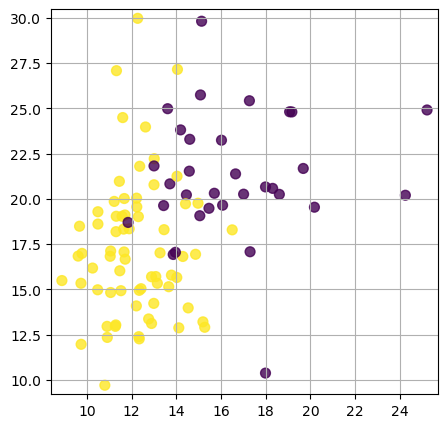

In [15]:
# quick insight to data
plt.figure(figsize=(5,5))
plt.scatter(x=trainX[:,0], y=trainX[:,1], s=50, alpha=0.8, c=trainY)
plt.xlim(trainX[:,0].min() - 0.5, trainX[:,0].max() + 0.5)
plt.ylim(trainX[:,1].min() - 0.5, trainX[:,1].max() + 0.5)
plt.grid()
plt.show()

In [16]:
# cost funtion
def cross_entropy():
    global testX, testY
    
    predictY = np.dot(testX, weight)
    loss = np.mean(np.exp(1 - predictY) * testY) + np.sum(np.exp(predictY) * (1 - testY))
    
    print(f"cost: {loss:.3f}")
# CE

def negative_log_likelihood():
    global testX, testY
    
    predictY = np.dot(testX, weight)
    loss = np.mean(np.exp(1 - predictY) * testY) + np.sum(np.exp(predictY) * (1 - testY))
    
    print(f"cost: {loss:.3f}")
# NLL

In [17]:
cross_entropy()
negative_log_likelihood()

cost: 3607621571992611328.000
cost: 3607621571992611328.000


In [18]:
sigmoid = lambda x, e=2.7182: 1 / (1 + e**(-x))
reLu = lambda x: np.array([max(0, obj) for obj in x])
seLu = lambda x, e=2.7182, a=1.0507: np.array([obj if obj >= 0 else a * (e**obj - 1) for obj in x])

# activation fn dictionary
actDict = {"sigmoid":sigmoid,"reLu":reLu,"seLu":seLu}

In [19]:
def gradient_descent_rule(name):
    global trainX, trainY, weight, lr
    
    activHX = actDict[name](np.dot(trainX, weight))
    weight -= (lr / trainX.shape[0]) * np.dot(trainX.T, (activHX - trainY))

In [20]:
for epoch in range(iterations):
    gradient_descent_rule("sigmoid")  # don't touch these

In [21]:
def predict(case):
    global weight
    
    if type(case) == list:
        case = np.array(case)
    
    return 1 if np.dot(case, weight) >= 0.5 else 0

In [22]:
index = random.randrange(len(testY))
prediction = predict(testX[index,:])
print(f"pred: {prediction}, actual target: {testY[index]}")

pred: 1, actual target: 1


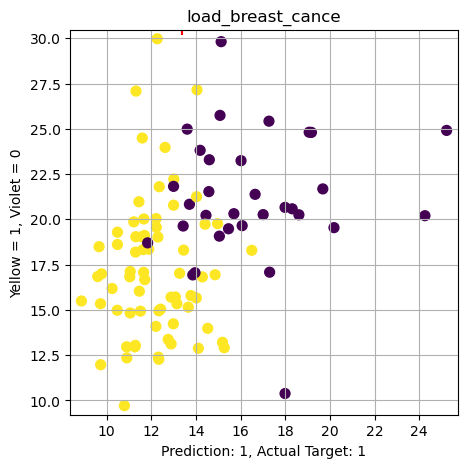

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(x=trainX[:,0], y=trainX[:,1], s=50, alpha=1, c=trainY)
plt.scatter(x=testX[index,0], y=testX[index,1], c='r', s=200, marker='+')
plt.xlim(trainX[:,0].min() - 0.5, trainX[:,0].max() + 0.5)
plt.ylim(trainX[:,1].min() - 0.5, trainX[:,1].max() + 0.5)
plt.grid()
plt.xlabel(f"Prediction: {prediction:.0f}, Actual Target: {testY[index]}")
plt.ylabel("Yellow = 1, Violet = 0")
plt.title("load_breast_cance")
plt.show()

In [24]:
# errors
cross_entropy()
negative_log_likelihood()

cost: 306.624
cost: 306.624
